# Calibrating the HBV model

## Setting up the python kernel

In [140]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

from rich import print
from tqdm import tqdm
from pathlib import Path
from ewatercycle_DA import DA
from datetime import datetime
from scipy.stats import qmc
from ipywidgets import IntProgress

## Loading in observed discharge data

In [157]:
# Loading in discharge data from Katima Mulilo
katima = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
    .drop(columns=['hh:mm'])
    .rename(columns={"YYYY-MM-DD": "Date", " Value": "Discharge [m^3/s]"}))

# Removing invalid data
km = katima[['Date', 'Discharge [m^3/s]']]
km['Discharge [m^3/s]'] = km['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Fixing the date column for accesibility 
km['Date'] = pd.to_datetime(km['Date'])

# Defining the calibration period
start_calibration = '1986-01-01'
end_calibration = '2019-12-31'

# Reducing the dataframe to the calibration period
km = km[(km['Date'] >= start_calibration) & (km['Date'] <= end_calibration)]

flow = pd.DataFrame(data=km['Discharge [m^3/s]'].values, index=km['Date'], columns=['Q'])

print(flow)
# # Defining the start and end of the dataset (in the format needed for the calibration)
# data_start = km['Date'].iloc[0].strftime('%Y-%m-%dT%H:%M:%SZ')
# data_end = km['Date'].iloc[-1].strftime('%Y-%m-%dT%H:%M:%SZ')

Q
Date              
1986-01-01  346.96
1986-01-02  353.18
1986-01-03  359.44
1986-01-04  365.71
1986-01-05  372.72
...            ...
2019-12-27  403.33
2019-12-28  406.55
2019-12-29  409.77
2019-12-30  413.00
2019-12-31  416.23

[12418 rows x 1 columns]

## Generating the ERA5 forcings 

In [158]:
#Defining the location of the shape file to be used
km_shp = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG" /  "km_ERA5" / "km.shp"

#Defining the forcings directory
ERA5_folder = Path.home() / "ERA5"
ERA5_folder.mkdir(exist_ok=True)

# HBV model path 
HBV_model_path = Path.home() / "HBV_model"

# OPTION 1: Generating ERA5 forcings
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    start_time= data_start,
#    end_time= data_end,
#    shape=km_shp,
#    directory=ERA5_folder)

# OPTION 2: Generating ERA5 forcings (For when ERA5 forcing has already been made before and exists in the directory)
load_location = ERA5_folder / "work" / "diagnostic" / "script" 
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

## Defining functions to determine the model of best fit

In [159]:
def calibrationObjective(modelOutput, observation, start, end):
    # Making sure the date of the modelled output and onserved input are in the correct format
    modelOutput.index = pd.to_datetime(modelOutput.index)
    observation.index = pd.to_datetime(observation.index)

    # Making sure the given dates are in the correct format
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    # Combine the model output and the observation into one data frame 
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method='ffill'), observation], axis=1, keys=['model', 'observation'])
    
    # Making sure to only take the calibration period
    hydro_data = hydro_data[(hydro_data.index > start) & (hydro_data.index < end)]

    # Calculate the absolute square difference
    squareDiff = (hydro_data['model'] - hydro_data['observation']) ** 2
    rootMeanSquareDiff = np.sqrt(np.mean(squareDiff))
    
    return rootMeanSquareDiff

## Start calibration

In [160]:
# Set the number of HBV model ensembles you will test against the observed discharge
N = 12

In [161]:
# Define the initial state parameters (Si,  Su, Sf, Ss, Sp)
s_0 = np.array([0,  100,  0,  5,  0])

# Define parameters and their corresponding boundary values 
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
# parameters = np.zeros([N, len(param_names)])

param_mins = np.array([0, 0.2, 40, 0.5, 0.001, 1, 0.01, 0.0001, 0.01])
param_maxs = np.array([8, 1, 800, 4, 0.3, 10, 0.1, 0.01, 1])

#Fill the parameters array with random values between each minimum and maximum
# for p in range(N-1):
#     parameters[:, p] = np.random.uniform(param_mins, param_maxs, N)

# Create a Latin Hypercube sampler
sampler = qmc.LatinHypercube(d=len(param_names))
sample = sampler.random(n=N)

# # Scale the sample to match the parameter ranges
parameters = qmc.scale(sample, param_mins, param_maxs)

In [162]:
# Observe the randomly chosen variables for each parameter to confirm their boundaries are adhered to
print(list(zip(param_names, np.round(parameters[0], decimals=3))))

[
    ('Imax', 0.94),
    ('Ce', 0.762),
    ('Sumax', 202.436),
    ('Beta', 1.942),
    ('Pmax', 0.178),
    ('Tlag', 2.734),
    ('Kf', 0.019),
    ('Ks', 0.009),
    ('FM', 0.332)
]

In [163]:
ensemble = []

for counter in range(N): 
    ensemble.append(ewatercycle.models.HBVLocal(forcing=ERA5_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = parameters[0],
                            initial_storage=s_0,
                            cfg_dir = HBV_model_path)
    ensemble[counter].initialize(config_file)

## ORIGINAL CODE 

# ensemble = DA.Ensemble(N=N)
# ensemble.setup()

# ensemble.initialize(model_name=["HBVLocal"]*N,
#                     forcing=[ERA5_forcing]*N,
#                     setup_kwargs=setup_kwargs_lst) 

In [164]:
f = IntProgress(min=0, max=N)
display(f)

# Array to store objective values
objectives = []

# Loop over ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))

    # Create DataFrame for model results
    # Q_m = convert_Qsim_mmday_to_m3s(np.array(Q_m), 334882.8)
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))

    # Calculate the custom drought-based objective function
    objective_this_model = calibrationObjective(
        discharge_dataframe, 
        km['Discharge [m^3/s]'], 
        start_calibration, 
        end_calibration
    )
    objectives.append(objective_this_model)

    # Free up memory
    del Q_m, time, discharge_dataframe, objective_this_model
    f.value += 1

# Clean up models to save memory
for ensembleMember in ensemble:
    ensembleMember.finalize()

IntProgress(value=0, max=12)

In [165]:
# Let's also show the minimal values:
parameters_minimum_index = np.argmin(np.array(objectives))
if np.min(np.array(objectives)) == np.inf:
    print("No real parameter is chosen")

parameters_minimum = parameters[parameters_minimum_index]

print(list(parameters_minimum))

[
    0.9395152455975891,
    0.7616376501010966,
    202.43615146767888,
    1.942010298441787,
    0.17831203621613761,
    2.7336825310471644,
    0.01879354824263224,
    0.009053681361150537,
    0.3316062865951755
]

## Graph

In [166]:
model = ewatercycle.models.HBV(forcing=ERA5_forcing)
config_file, _ = model.setup(
    parameters=parameters_minimum, 
    initial_storage=s_0,
    cfg_dir = HBV_model_path,
)

In [167]:
model.initialize(config_file)

In [168]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [169]:
model.finalize()

<Axes: xlabel='Date'>

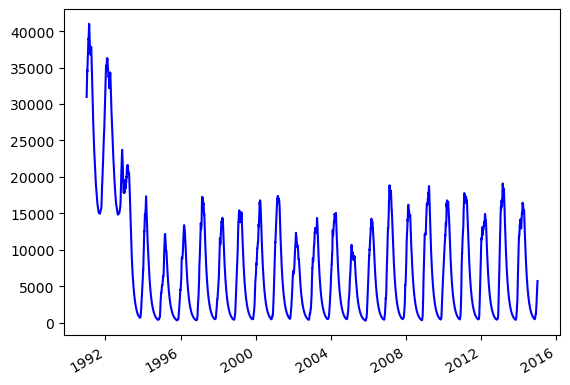

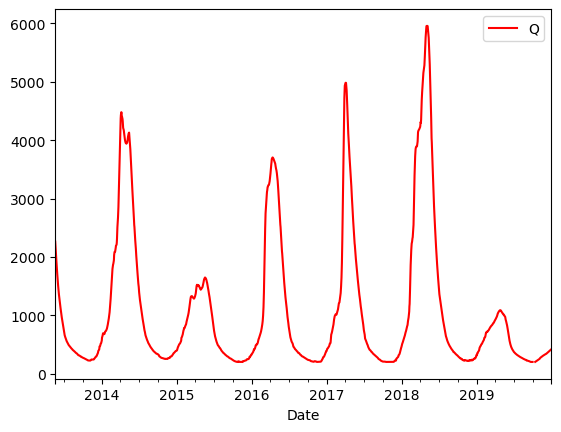

In [176]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

def convert_Qsim_mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

Q_sim = convert_Qsim_mmday_to_m3s(model_output.values, 334882.8)
Q_sim_pd = pd.Series(Q_sim, index=model_output.index, name="Simulated Discharge")

Q_sim_date = Q_sim_pd["1990-12-31":"2014-12-31"]

Q_sim_date.plot(color='b')
flow[10000:12418].plot(color='r')

## My original code

In [ ]:
# ref_model = ensemble.ensemble_list[0].model

In [ ]:
# timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)

# time = []
# lst_Q = [] 

# for t in tqdm(range(timesteps)):    
#     time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
#     ensemble.update()
#     lst_Q.append(ensemble.get_value("Q").flatten())

In [ ]:
# ensemble.finalize()

In [ ]:
# Q_m_arr = np.array(lst_Q).T
# df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(N)])

In [ ]:
# objective_values = []

# data_start = pd.to_datetime(km['Date'].iloc[0])
# data_end = pd.to_datetime(km['Date'].iloc[-1])

# for i in tqdm(range(N)):
#     objective_values.append(calibrationObjective(df_ensemble.iloc[:,i],km['Discharge [m^3/s]'],data_start,data_end))


In [ ]:
# parameters_minimum_index = np.argmin(np.array(objective_values))

# parameters_minimum = parameters[:,parameters_minimum_index]

# print(list(zip(param_names, np.round(parameters_minimum, decimals=3))))